In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import random
import os

2022-07-03 11:01:51.088046: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

## Build Source Domain Network

In [3]:
from models import encoder, unet

s_encoder = encoder.get_model()
u_net = unet.get_model()
s_model = keras.models.Model(
    inputs=s_encoder.inputs,
    outputs=u_net(s_encoder(s_encoder.inputs))
)

2022-07-03 11:01:53.238442: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-03 11:01:53.238897: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-03 11:01:53.288156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 11:01:53.288313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-07-03 11:01:53.288325: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-03 11:01:53.305532: I tensorflow/stream_executor/platfor

## Load Zurich dataset as source dataset
- https://docs.google.com/forms/d/e/1FAIpQLSdH6Pqdlu0pk2vGZlazqoRYwWsxN3nsLFwYY6Zc5-RUjw3SdQ/viewform

In [4]:
base_dir = "/home/gosha20777/Zurich-RAW-to-DSLR-Dataset"
train_input_dir = os.path.join(base_dir, "train/huawei_raw")
train_target_dir = os.path.join(base_dir, "train/canon")
test_input_dir = os.path.join(base_dir, "test/huawei_raw")
test_target_dir = os.path.join(base_dir, "test/canon")
img_size = (224, 224)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".jpg")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(test_target_dir, fname)
        for fname in os.listdir(test_target_dir)
        if fname.endswith(".jpg")
    ]
)


print("Number of samples:", len(input_img_paths))
print("Number test of samples:", len(test_input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))

Number of samples: 46839
Number test of samples: 1204
0.png | 0.jpg
1.png | 1.jpg
10.png | 10.jpg
100.png | 100.jpg
1000.png | 1000.jpg
10000.png | 10000.jpg
10001.png | 10001.jpg
10002.png | 10002.jpg
10003.png | 10003.jpg
10004.png | 10004.jpg


In [5]:
from datasets.huavei import HuaveiLoader

val_samples = 4000
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
val_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)
test_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, test_input_img_paths, test_target_img_paths
)

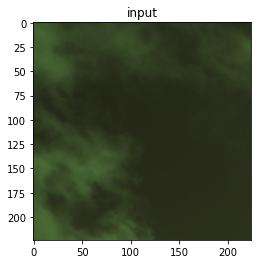

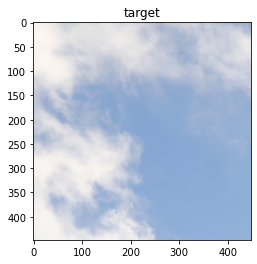

In [6]:
x, y = train_gen.__getitem__(0)
plt_display(x[3][:,:,0:3], 'input')
plt_display(y[3], 'target')

## Train Source Model

In [21]:
from losses.losses import mssim, vgg_loss

def main_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred) + \
        mssim(y_true, y_pred) + \
        vgg_loss(y_true, y_pred)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

In [ ]:
s_model.compile(optimizer="adam", loss=main_loss)

epochs = 4

callbacks = [
    keras.callbacks.ModelCheckpoint("s_model.h5", save_best_only=True)
]


s_model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, workers=8)

2022-07-02 19:28:06.648654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-02 19:28:06.665297: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3792880000 Hz


Epoch 1/4


2022-07-02 19:28:07.816783: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-02 19:28:08.383311: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-07-02 19:28:08.436268: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-07-02 19:28:09.672140: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


5354/5354 [==============================] - 2141s 391ms/step - loss: 1.0525 - val_loss: 0.7963
Epoch 2/4
5354/5354 [==============================] - 2098s 392ms/step - loss: 0.7958 - val_loss: 0.7763
Epoch 3/4
5354/5354 [==============================] - 2097s 392ms/step - loss: 0.7805 - val_loss: 0.7715
Epoch 4/4
3851/5354 [====================>.........] - ETA: 9:22 - loss: 0.7740

### Evaluate

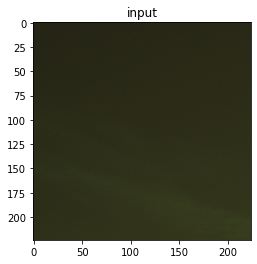

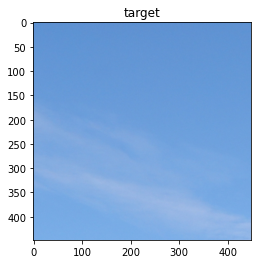

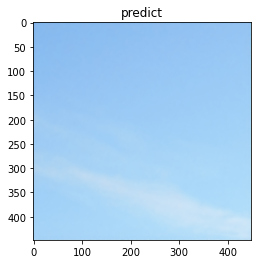

In [22]:
s_model.compile(optimizer="adam", loss=main_loss, metrics=[psnr, ssim])
s_model.load_weights('s_model.h5')

x, y = test_gen.__getitem__(1)
preds = s_model.predict(x)
plt_display(x[0][:,:,0:3], 'input')
plt_display(y[0], 'target')
plt_display(preds[0], 'predict')

In [24]:
print("Evaluate on test data")
_, psnr_val, ssim_val = s_model.evaluate(test_gen)
print(f"psnr: {psnr_val}, ssim: {ssim_val}")


Evaluate on test data
150/150 [==============================] - 25s 169ms/step - loss: 0.8191 - psnr: 19.7222 - ssim: 0.7236
psnr: 19.72218132019043, ssim: 0.7235944867134094
